### Important Note

This notebook was presented at EBI Workshop on Machine Leaning in September 2018.

Author: Dr. Ekaterina Volkova-Volkmar

More detials and code can be found here: https://www.kaggle.com/jboysen/mri-and-alzheimers


# Classification of dementia by parameters of structural medical images of the encephalon in conjunction with cognition tests
----



Import needed libraries. Latest versions (for September 2018) for all libraries for python 3.6 were used. More information is in the pip_freeze.txt file. 

In [1]:
from scipy import stats
from sklearn.preprocessing import StandardScaler

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split, validation_curve, cross_val_score
from sklearn import metrics

from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from sklearn.datasets import make_classification

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score

from collections import defaultdict
from sklearn.metrics import f1_score

To check your package versions, uncomment and run the line below. You don't need to install all librabies on the list though, just check the version of those imported in the notebook.

In [2]:
#!pip freeze

It is generally not good practice to suppress warnings (also in life :D) but I was getting a lot of warnings from sklearn. After research I found that it is a currenlty unfixed issue and that warning should not have been there. Comment this line and restart the kernel if you want all the warnings.

In [3]:
import warnings; warnings.simplefilter('ignore')


Load helper functions: - the author is this brilliant Kaggle member: https://www.kaggle.com/ruslankl, I only made a couple small changes

1. Outlier identification
2. Detailed confusion matrix
3. Report on the model's performance

In [4]:
def outliers_z_score(ys,threshold):
    
    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    outliers = [x for x in z_scores if np.abs(x) > threshold]

    return np.where(np.abs(z_scores) > threshold)

In [5]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];
    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN
    
    AP = tp+fp
    
    f1_w = 2*((tp/AP)*(tp/NP))/((tp/AP)+(tp/NP))

    fig = plt.figure(figsize=(6,6))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f\n(F1: %.2f)'%((tp+tn+0.)/N, f1_w),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()
  

In [6]:
def report_performance(model, X_test, y_test):

    model_test = model.predict(X_test)
    
    cm = metrics.confusion_matrix(y_test, model_test)
    show_confusion_matrix(cm)

In [7]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Read in Data

Read in longitudinal data

In [8]:
df_long = pd.read_csv('./data/oasis_longitudinal.csv')

Check for missing data

In [9]:
temp_df = pd.DataFrame(df_long.isnull().sum()/df_long.shape[0])
temp_df[temp_df[0]>0.0]

,0
SES,0.050938
MMSE,0.005362


Some data in 'SES' and 'MMSE' is missing, we fill the missing data in with corresponding mean values (this is just one of possible strategies)

In [10]:
df_long["SES"].fillna(df_long["SES"].mean(), inplace=True)
df_long["MMSE"].fillna(df_long["MMSE"].mean(), inplace=True)

How many records per patient on average?

In [11]:
df_long.shape[0] / len(df_long["Subject ID"].unique()) 

2.486666666666667

If we use all the data we might have same patient's data in traning and testing (data leaking). We turn this longitudinal data set into cross-sectional one by extracting last event for every patient and discarding the rest of the data.

In [12]:
idx = df_long.groupby(["Subject ID"])['Visit'].transform(max) == df_long['Visit']
df_long_selected = df_long[idx]

These are the columns we want to keep: "Subject ID", "M/F", "Age", "EDUC", 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF'

In [13]:
df_long_selected = df_long_selected[["Subject ID", "M/F", "Age", "EDUC", 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']]

Load cross-sectional data

In [14]:
cross_data = pd.read_csv('./data/oasis_cross-sectional.csv')

Rename a couple columns and select columns with names that occur in the 'longitudinal' dataset

In [15]:
cross_data = cross_data.rename(columns={"Educ": "EDUC", "ID": "Subject ID"})
cross_data_clean = cross_data[df_long_selected.columns]

Check for missing data

In [16]:
temp_df = pd.DataFrame(cross_data_clean.isnull().sum()/cross_data_clean.shape[0])
temp_df[temp_df[0]>0.0]

,0
EDUC,0.461009
SES,0.504587
MMSE,0.461009
CDR,0.461009


Too much missing data to fill in with anything meaningfull! We will have to get rid of row that have NA's

In [17]:
cross_data_clean = cross_data_clean.dropna()

Is there overlap between subject IDs in the two sets? Nope. This is good, we want only one record per patient in the final dataset.

In [18]:
set(df_long["Subject ID"].unique()) & set(cross_data["Subject ID"].unique())

set()

Let's join the datasets!

In [19]:
data_final = pd.concat([cross_data_clean, df_long_selected])
data_final.head()

,Subject ID,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS1_0001_MR1,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,OAS1_0002_MR1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,OAS1_0003_MR1,F,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
8,OAS1_0010_MR1,M,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
9,OAS1_0011_MR1,F,52,3.0,2.0,30.0,0.0,1321,0.827,1.329


We have 366 records

In [20]:
data_final.shape

(366, 10)

Get rid of the patient ID

In [21]:
data_final = data_final.drop("Subject ID", axis=1)

Investigate CDR distribution - this is the value we want to predict

In [22]:
data_final["CDR"].value_counts()

0.0    206
0.5    110
1.0     45
2.0      5
Name: CDR, dtype: int64

Map everything above 0 to 1, this makes the class distribution more balanced. We are now dealing with a binary classification of "not demented" vs. "demented".

In [23]:
data_final["CDR"] = (data_final["CDR"] > 0).map(int)
data_final["CDR"].value_counts()

0    206
1    160
Name: CDR, dtype: int64

Map gender labels into numbers so that all columns are numeric

In [24]:
gender_map = {"M": 0, "F": 1}
data_final['M/F'] = data_final['M/F'].map(gender_map)

Look at feature cross-correlation

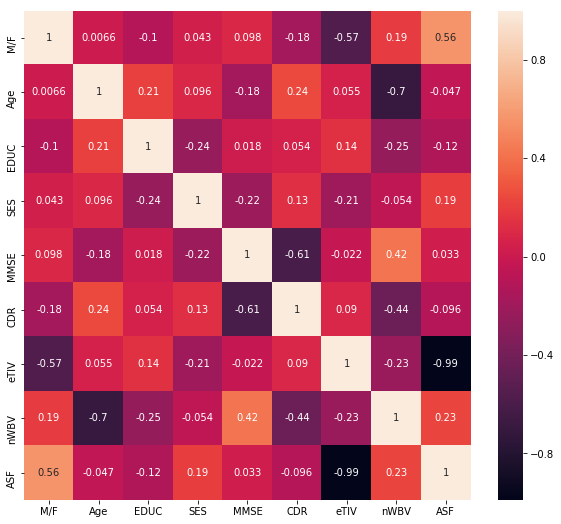

In [25]:
fig, ax = plt.subplots(figsize=(10,9))
sns.heatmap(data_final.corr(), annot=True, ax=ax )

'ASF' and 'eTIV' are negatively cross-correlated (corr=-0.99), we only need one of them, we remove eTIV from the dataset.

In [26]:
data_final = data_final.drop(["eTIV"], axis=1)

Look at data distribution - especially columns with numeric values on a granular scale should be controlled for normal distribution

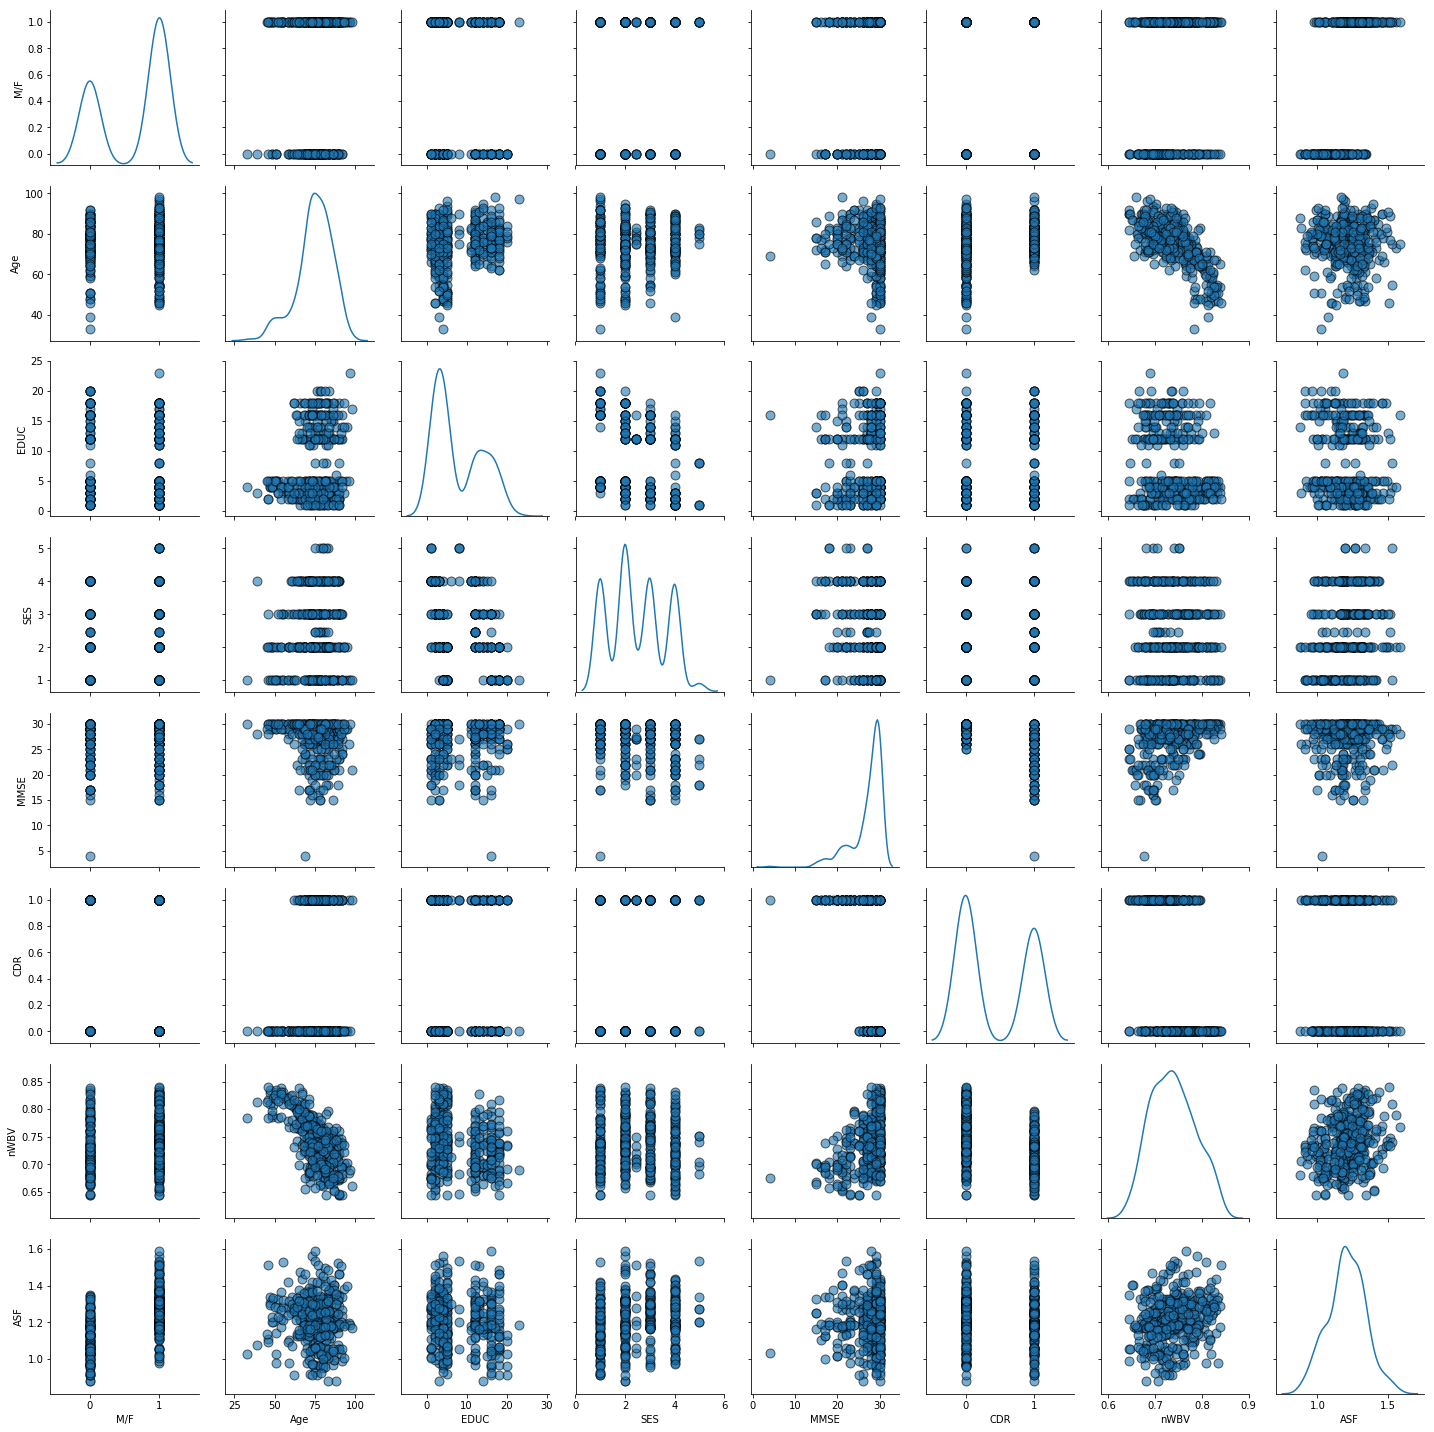

In [27]:
sns.pairplot(data_final, diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'})

Age and MMSE are skewed - we normalise them

In [28]:
data_final["Age"], _ = stats.boxcox(data_final["Age"])
data_final["MMSE"], _ = stats.boxcox(data_final["MMSE"])

Check for outliers in the following columns: 'Age', 'EDUC', 'SES', 'MMSE', 'nWBV', 'ASF'

In [29]:
list_atributes = ['Age', 'EDUC', 'SES', 'MMSE', 'nWBV', 'ASF']

for item in list_atributes:
    print(item, outliers_z_score(data_final[item], threshold=3))

Age (array([], dtype=int64),)
EDUC (array([], dtype=int64),)
SES (array([], dtype=int64),)
MMSE (array([], dtype=int64),)
nWBV (array([], dtype=int64),)
ASF (array([], dtype=int64),)


Scale columns so that they have mean=0 and std=1. 

In [30]:
scaler = StandardScaler()
data_final_rescaled = pd.DataFrame(scaler.fit_transform(data_final[list_atributes]), columns=list_atributes)

We don't rescale the CDR and gender - they are binary anyway

In [31]:
data_final_rescaled['CDR'] = list(data_final['CDR'])
data_final_rescaled['M/F'] = list(data_final['M/F'])

Assemble the dataset - features and label

In [32]:
feature_col_names = ["M/F", "Age", "EDUC", "SES", "MMSE", "nWBV", "ASF"]
predicted_class_names = ['CDR']

X = data_final_rescaled[feature_col_names].values
y = data_final_rescaled[predicted_class_names].values

split_test_size = 0.2

This line sets random seed and ensures you will get the same results I did. Set it to None to test results variability

In [33]:
random_st = 0

We split the dataset into train (80%) and the hold test (20%), stratified shuffle split makes sure the class ratio is preserved across splits

In [34]:
train_test = StratifiedShuffleSplit(n_splits=1, test_size = split_test_size, random_state=random_st)

for train_index, test_index in train_test.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

We will follow the same approach for three classifiers: Decision Trees, Random Forests, XGBoost:

- We will do 20-cross validation on the Training data (90% / 10%) 
- We will test the performace on the hold-out test data

All claffiriers are taken with default settings but you are welcome to play with hyper-parameters

In [35]:
names = ["Decision Tree", "Random Forest", "XGBoost"]

classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier()]

We split train set into 90% train and 10% validaction, 10 times, and train each of three models on each split, recording their f1_weighted performance on the validation dataset. Then we average the performance over all splits for each model

In [36]:
skf = StratifiedKFold(n_splits=10, random_state=random_st)

model_performance = defaultdict(list)

for train_val_index, val_index in skf.split(X_train, y_train):
    X_val_train, X_val = X[train_val_index], X[val_index]
    y_val_train, y_val = y[train_val_index], y[val_index]
    
    for name, clf in zip(names, classifiers):
        model = clf.fit(X_val_train, y_val_train.flatten())
        model_pred = model.predict(X_val)
        model_performance[name].append(f1_score(y_val, model_pred, average='weighted'))

for name in names:
    print("%s validation dataset accuracy: %0.2f (+/- %0.2f)" % (name, np.mean(model_performance[name]), np.std(model_performance[name])))
    

Decision Tree validation dataset accuracy: 0.78 (+/- 0.04)
Random Forest validation dataset accuracy: 0.84 (+/- 0.07)
XGBoost validation dataset accuracy: 0.85 (+/- 0.06)


Random forest and XGBoost have very similar performance on the validation dataset, but what will be there score on the hold out test? 

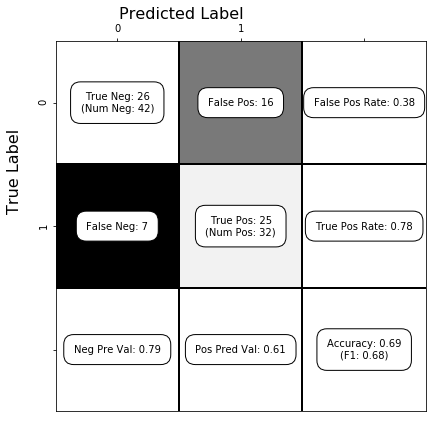

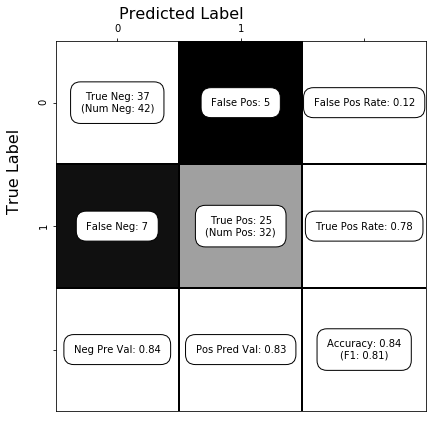

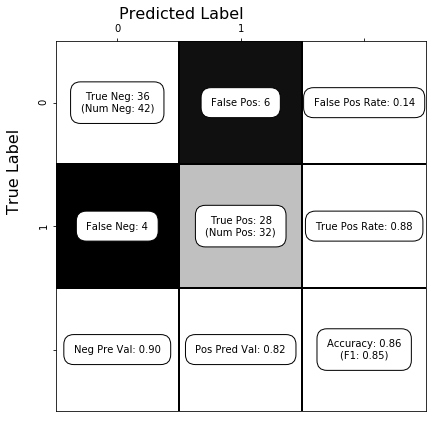

In [37]:
for name, clf in zip(names, classifiers):
    model = clf.fit(X_train, y_train.flatten())
    model_test = model.predict(X_test)
    
    model = clf.fit(X_train, y_train.flatten())
    report_performance(model, X_test, y_test.flatten())

The last 'model' object in our iteration was assigned to XGBoost. It also had highest performance on the hold-out test set. Let's see what features are important for this model.

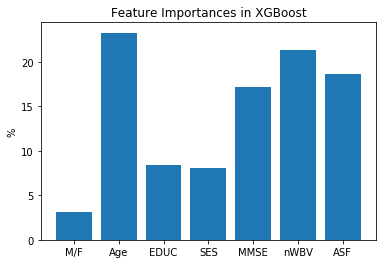

In [38]:
plt.bar(range(len(model.feature_importances_)), model.feature_importances_*100)
plt.xticks(range(len(model.feature_importances_)), feature_col_names)
plt.title("Feature Importances in XGBoost")
plt.ylabel("%")
plt.show()